In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATASETS=["dataset_manish.csv", "pong_dataset_20_min_ali.csv",
          "pong_dataset_20_min_ali2.csv", "pong_dataset_40_min_shankar.csv"]
data = pd.DataFrame()
for path in DATASETS:
  df=pd.read_csv(path)
  data=pd.concat([data, df])

In [ ]:
data.head()

,ball_x,ball_y,ball_dx,ball_dy,paddle_y,action
0,404,304,4,4,250,0
1,408,308,4,4,250,0
2,412,312,4,4,250,0
3,416,316,4,4,250,0
4,420,320,4,4,250,0


In [ ]:
data.shape

(423952, 6)

In [ ]:
data.describe()

,ball_x,ball_y,ball_dx,ball_dy,paddle_y,action
count,423952.000000,423952.000000,423952.000000,423952.000000,423952.000000,423952.000000
mean,421.662169,295.685755,-0.090237,-0.009869,264.590225,0.448777
std,214.040020,171.237798,3.998987,3.999993,167.198796,0.739359
min,0.000000,-3.000000,-4.000000,-4.000000,0.000000,0.000000
25%,236.000000,148.000000,-4.000000,-4.000000,120.000000,0.000000
50%,420.000000,296.000000,-4.000000,-4.000000,275.000000,0.000000
75%,608.000000,444.000000,4.000000,4.000000,420.000000,1.000000
max,792.000000,593.000000,4.000000,4.000000,500.000000,2.000000


In [ ]:
data.duplicated().sum()

np.int64(12893)

In [ ]:
# prompt: values count of action of duplicated records

duplicated_rows = data[data.duplicated()]
print(duplicated_rows['action'].value_counts())

action
0    12262
1      362
2      269
Name: count, dtype: int64


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data['action'].value_counts()

,count
action,
0,284869
2,63170
1,63020


In [ ]:
WIDTH, HEIGHT = 800, 600
PADDLE_WIDTH, PADDLE_HEIGHT = 10, 100
data.loc[(data['paddle_y'] == 0) & (data['ball_y'] > 50), "action"] = 2
data.loc[(data['paddle_y'] == HEIGHT - PADDLE_HEIGHT) & (data['ball_y'] < HEIGHT - 50), "action"] = 1

In [ ]:
def exploratory_data_analysis(df):
  #correlation matrix
  corr_matrix = df.corr()
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()
  for col in df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

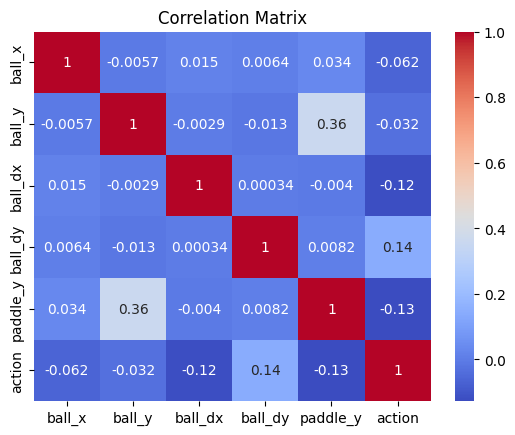

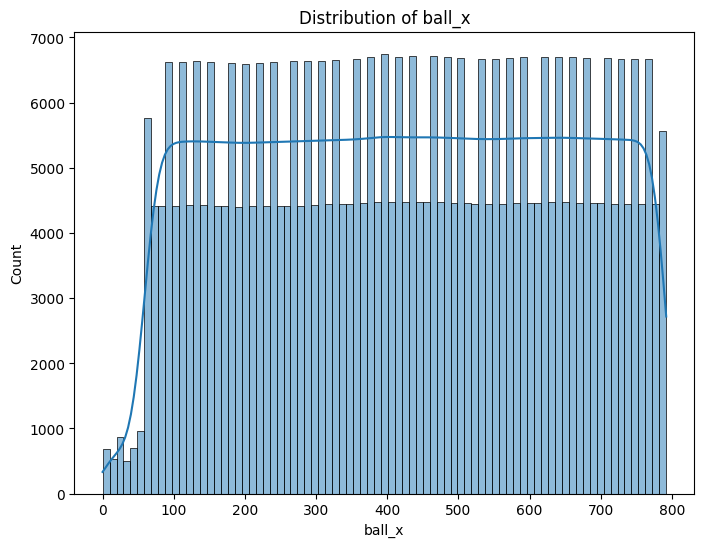

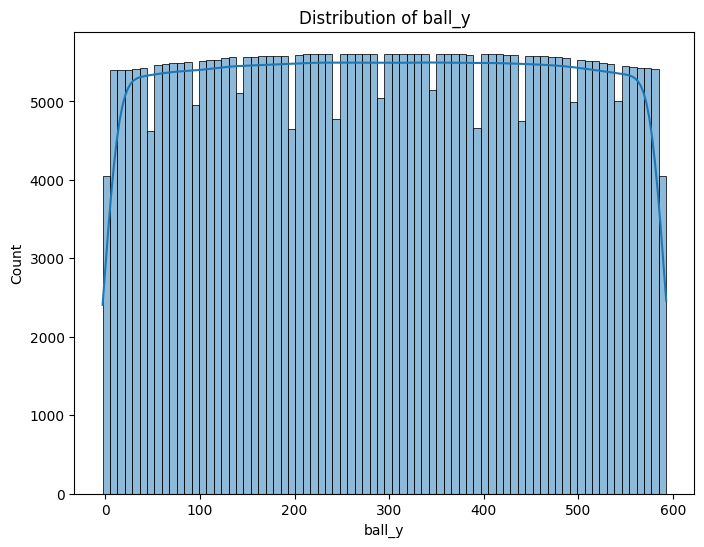

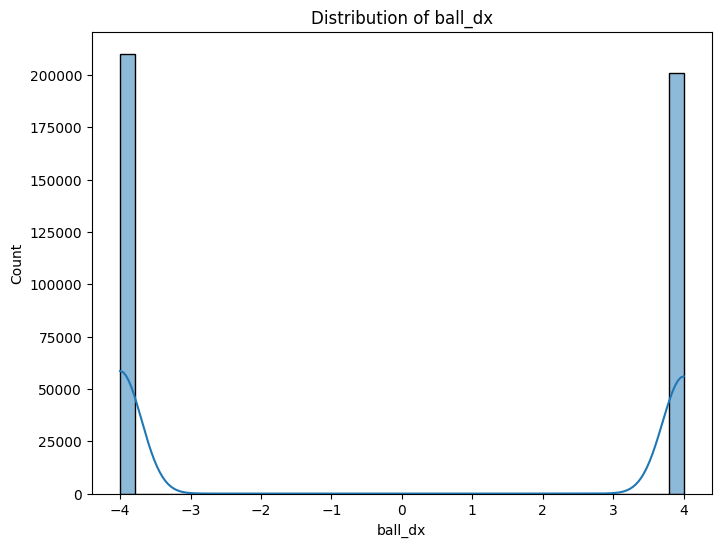

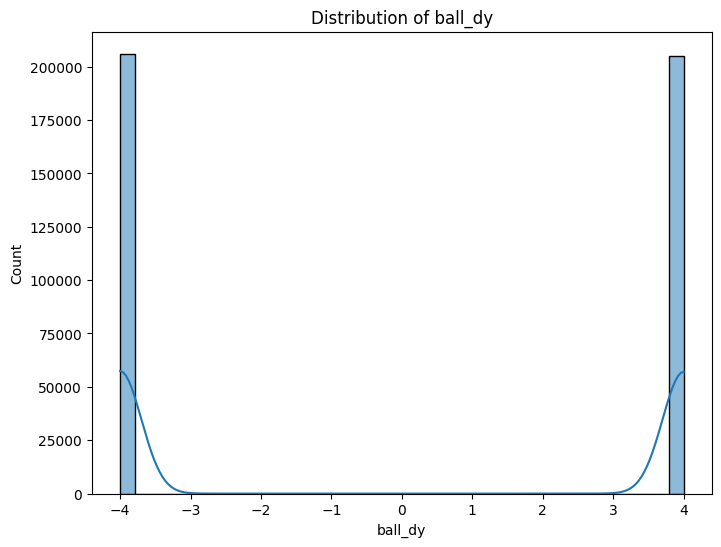

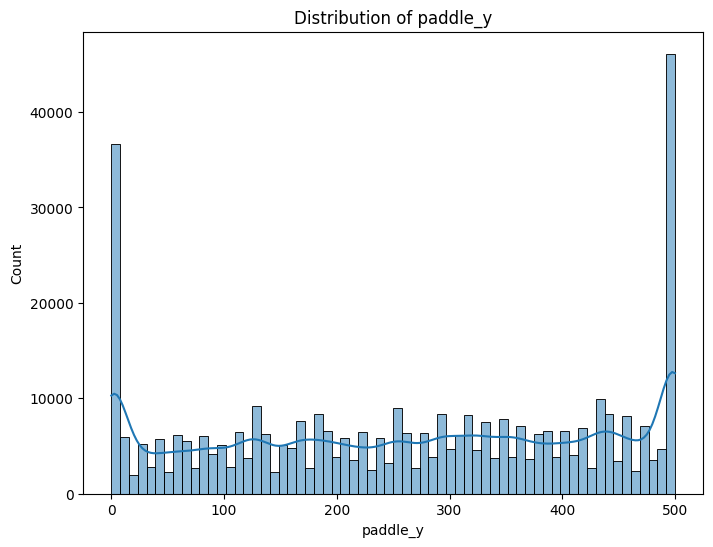

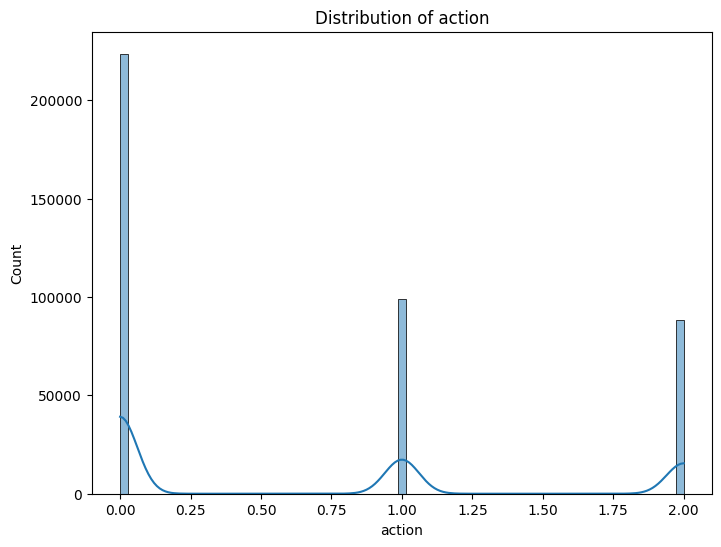

In [ ]:
exploratory_data_analysis(data)

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['ball_x', 'ball_y', 'ball_dx', 'ball_dy', 'paddle_y']
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

In [ ]:
# Separate classes
class_0 = data[data['action'] == 0]
class_1 = data[data['action'] == 1]
class_2 = data[data['action'] == 2]

# Find the smallest class size
min_count = min(len(class_1), len(class_2))

# Randomly sample class 0 to match smaller classes
class_0_sampled = class_0.sample(min_count, random_state=42)

# Combine all balanced classes
balanced_data = pd.concat([class_0_sampled, class_1, class_2], ignore_index=True)

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced action distribution:")
print(balanced_data['action'].value_counts())

Balanced action distribution:
action
1    99029
0    88408
2    88408
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = balanced_data.drop('action', axis=1)
y = balanced_data['action']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
def evaluate_model(model, X_test, y_test):
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
  import seaborn as sns
  import matplotlib.pyplot as plt
  import numpy as np

  # Predict on test set
  y_pred_proba = model.predict(X_test)

  # Convert probabilities to class labels for sklearn metrics
  if isinstance(y_pred_proba, np.ndarray) and y_pred_proba.ndim > 1:
    y_pred = np.argmax(y_pred_proba, axis=1)
  else:
    y_pred = y_pred_proba


  # Accuracy
  print("Accuracy:", accuracy_score(y_test, y_pred))

  #auc roc score
  # For multi-class classification, use 'ovr' or 'ovo'
  try:
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    print("AUC-ROC Score:", auc_roc)
  except AttributeError:
    print("AUC-ROC Score cannot be calculated for this model (predict_proba not available).")
  except ValueError as e:
    print(f"Could not calculate AUC-ROC Score: {e}")


  # Classification report
  print(classification_report(y_test, y_pred))

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def save_model(model, filename):
  import pickle
  with open(filename, 'wb') as file:
    pickle.dump((model, scaler), file)

#Random Forest Classifier

Accuracy: 0.8301401149196107
AUC-ROC Score: 0.9542388583256963
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     17682
           1       0.87      0.87      0.87     19806
           2       0.85      0.84      0.84     17681

    accuracy                           0.83     55169
   macro avg       0.83      0.83      0.83     55169
weighted avg       0.83      0.83      0.83     55169



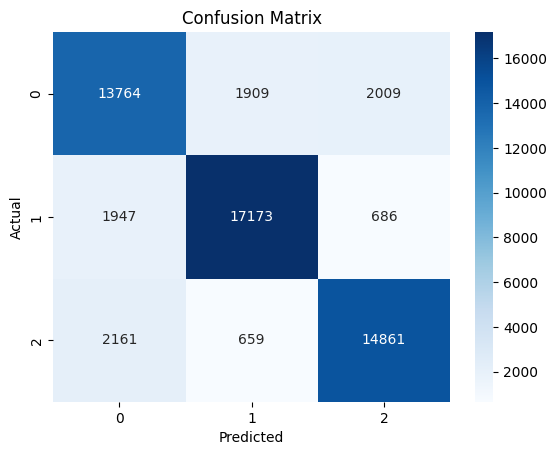

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)
# save_model(rf, "random_forest_model.pkl")

#XGBoost Classifier



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:24:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7577081331907412
AUC-ROC Score: 0.9071000709079495
              precision    recall  f1-score   support

           0       0.69      0.61      0.65     17682
           1       0.81      0.83      0.82     19806
           2       0.76      0.83      0.79     17681

    accuracy                           0.76     55169
   macro avg       0.75      0.75      0.75     55169
weighted avg       0.75      0.76      0.75     55169



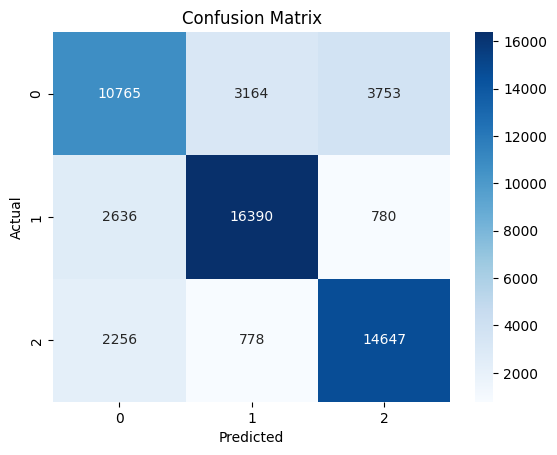

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='mlogloss'  # for multi-class classification
)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test)
# save_model(xgb, "xgboost_model.pkl")

#LIGHT BGM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 220676, number of used features: 5
[LightGBM] [Info] Start training from score -1.137882
[LightGBM] [Info] Start training from score -1.024429
[LightGBM] [Info] Start training from score -1.137868
Accuracy: 0.7932172053145788
AUC-ROC Score: 0.9299062473311404
              precision    recall  f1-score   support

           0       0.73      0.70      0.71     17682
           1       0.84      0.85      0.84     19806
           2       0.81      0.82      0.81     17681

    accuracy                           0.79     55169
   macro avg       0.79      0.79      0.79     55169
weighted avg       0.79      0.79      0.79     55169



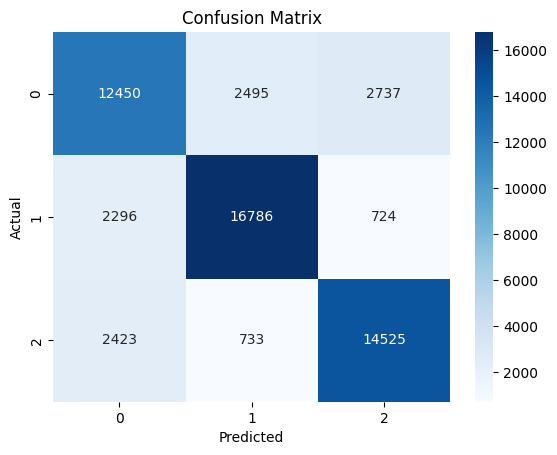

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)
evaluate_model(lgbm, X_test, y_test)
# save_model(lgbm, "lightgbm_model.pkl")

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


#CAT BOOST

Accuracy: 0.3205060813137813
AUC-ROC Score: 0.9080254452632799


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.32      1.00      0.49     17682
           1       0.00      0.00      0.00     19806
           2       0.00      0.00      0.00     17681

    accuracy                           0.32     55169
   macro avg       0.11      0.33      0.16     55169
weighted avg       0.10      0.32      0.16     55169



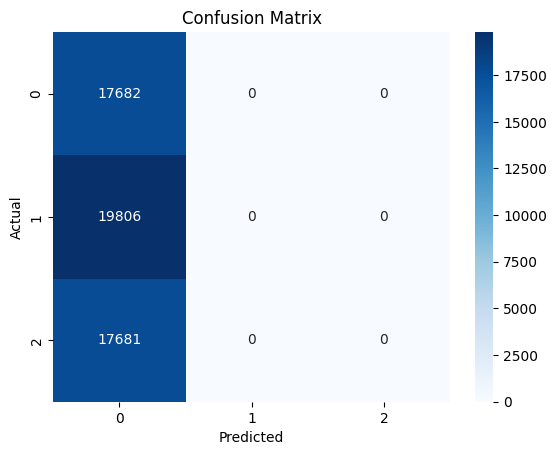

In [ ]:
import catboost as cb
cb_model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, loss_function='MultiClass')
cb_model.fit(X_train, y_train, verbose=False)
evaluate_model(cb_model, X_test, y_test)
# save_model(cb_model, "catboost_model.pkl")

#LOGISTIC REGRESSION

Accuracy: 0.5781145208359767
AUC-ROC Score: 0.7595665837981341
              precision    recall  f1-score   support

           0       0.39      0.22      0.29     17682
           1       0.62      0.77      0.69     19806
           2       0.62      0.71      0.66     17681

    accuracy                           0.58     55169
   macro avg       0.54      0.57      0.55     55169
weighted avg       0.55      0.58      0.55     55169



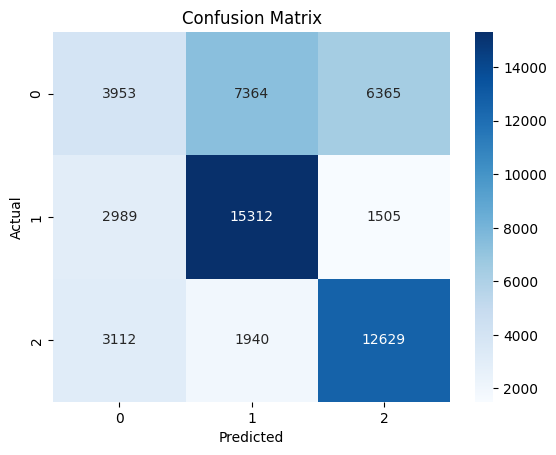

In [ ]:
import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test)
# save_model(lr, "logistic_regression_model.pkl")

#KNN

Accuracy: 0.8367742754082909
AUC-ROC Score: 0.955963708299789
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     17682
           1       0.86      0.90      0.88     19806
           2       0.85      0.86      0.85     17681

    accuracy                           0.84     55169
   macro avg       0.83      0.83      0.83     55169
weighted avg       0.84      0.84      0.84     55169



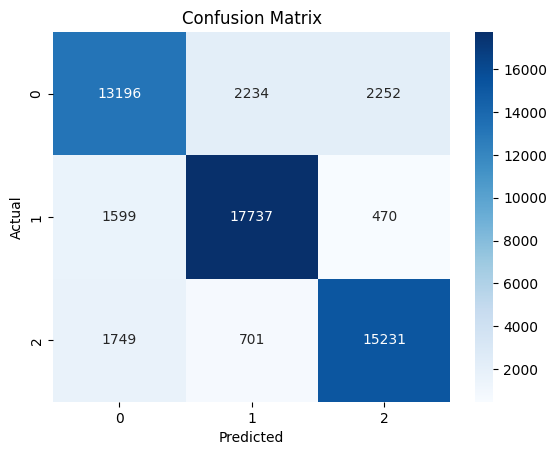

In [ ]:
import sklearn.neighbors as kn
knn = kn.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
evaluate_model(knn, X_test, y_test)
# save_model(knn, "knn_model.pkl")

#Decision Tree

Accuracy: 0.7989269336040168
AUC-ROC Score: 0.848750677653778
              precision    recall  f1-score   support

           0       0.73      0.74      0.73     17682
           1       0.85      0.84      0.84     19806
           2       0.82      0.81      0.82     17681

    accuracy                           0.80     55169
   macro avg       0.80      0.80      0.80     55169
weighted avg       0.80      0.80      0.80     55169



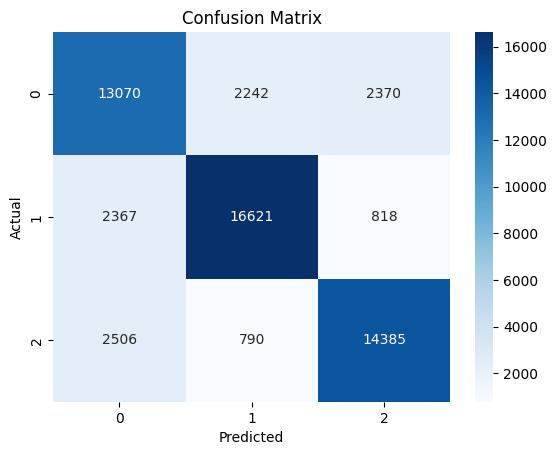

In [ ]:
import sklearn.tree as tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
evaluate_model(dt, X_test, y_test)
# save_model(dt, "decision_tree_model.pkl")

#NAIVE BAYES

Accuracy: 0.5855099784299154
AUC-ROC Score: 0.7670490780262652
              precision    recall  f1-score   support

           0       0.42      0.24      0.31     17682
           1       0.62      0.79      0.69     19806
           2       0.63      0.70      0.66     17681

    accuracy                           0.59     55169
   macro avg       0.56      0.58      0.55     55169
weighted avg       0.56      0.59      0.56     55169



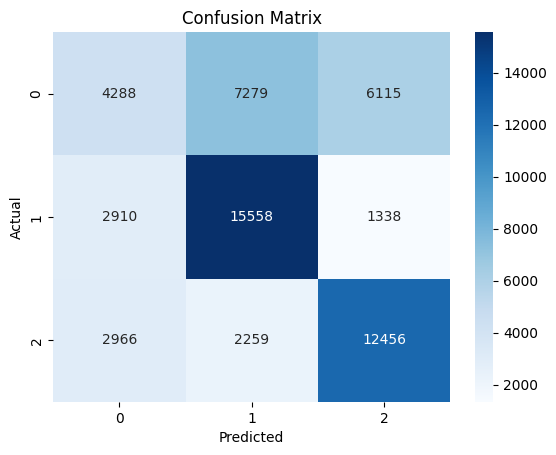

In [ ]:
import sklearn.naive_bayes as nb
nb = nb.GaussianNB()
nb.fit(X_train, y_train)
evaluate_model(nb, X_test, y_test)
# save_model(nb, "naive_bayes_model.pkl")

#Neural Network

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6269 - loss: 0.8145 - val_accuracy: 0.7413 - val_loss: 0.6193
Epoch 2/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7326 - loss: 0.6496 - val_accuracy: 0.7690 - val_loss: 0.5654
Epoch 3/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7510 - loss: 0.6171 - val_accuracy: 0.7776 - val_loss: 0.5570
Epoch 4/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7559 - loss: 0.6048 - val_accuracy: 0.7792 - val_loss: 0.5444
Epoch 5/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7643 - loss: 0.5936 - val_accuracy: 0.7834 - val_loss: 0.5362
Epoch 6/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7657 - loss: 0.5880 - val_accuracy: 0.7832 - val_loss: 0.5328
Epoch 7/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7655 - loss: 0.5862 - val_accuracy: 0.7850 - val_loss: 0.5310
Epoch 8/50
5517/5517 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7681 - loss: 0

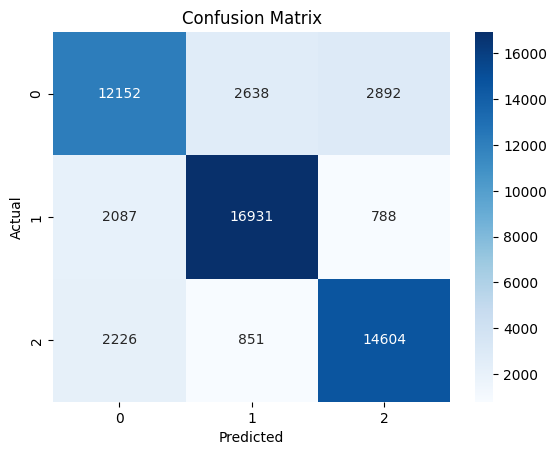

In [ ]:
#neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True)
nn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])
def evaluate_nn(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
evaluate_nn(nn, X_test, y_test)
save_model(nn, "neural_network_model.pkl")

1725/1725 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


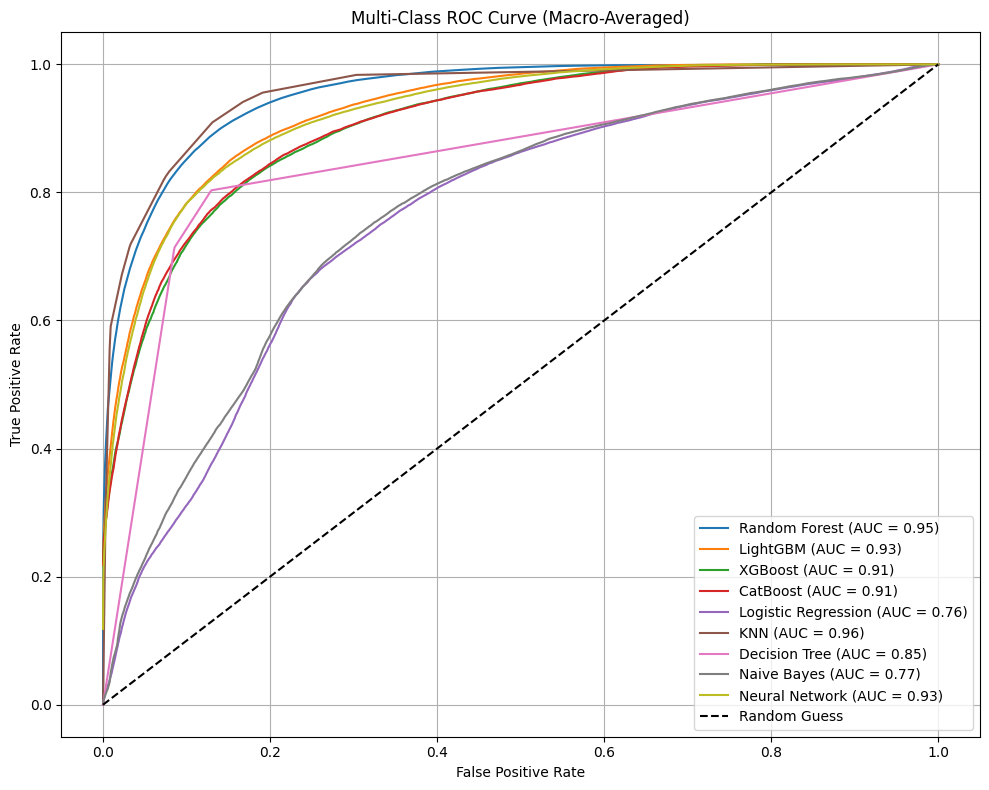

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Assuming your labels are like [0, 1, 2]
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_rf = rf.predict_proba(X_test)
y_pred_lgbm = lgbm.predict_proba(X_test)
y_pred_xgb = xgb.predict_proba(X_test)
y_pred_cb = cb_model.predict_proba(X_test)
y_pred_lr = lr.predict_proba(X_test)
y_pred_knn = knn.predict_proba(X_test)
y_pred_dt = dt.predict_proba(X_test)
y_pred_nb = nb.predict_proba(X_test)
y_pred_nn = nn.predict(X_test)
# Store models and predictions
models = {
    "Random Forest": y_pred_rf,
    "LightGBM": y_pred_lgbm,
    "XGBoost": y_pred_xgb,
    "CatBoost": y_pred_cb,
    "Logistic Regression": y_pred_lr,
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_dt,
    "Naive Bayes": y_pred_nb,
    "Neural Network": y_pred_nn
}

plt.figure(figsize=(10, 8))

# Plot each model's macro-average ROC curve
for name, y_pred_proba in models.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro and macro averages
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot macro-average curve
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (Macro-Averaged)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Use the same model type (don't pass the fitted model)
from sklearn.neighbors import KNeighborsClassifier
knn_for_tuning = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_for_tuning,
    param_grid=param_grid,
    scoring='roc_auc_ovr',   # or 'f1_macro', 'roc_auc_ovr' for multi-class
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model and params
print("Best Parameters:", grid_search.best_params_)
print("Best AUC ROC (CV):", grid_search.best_score_)

# Use the best model
best_knn = grid_search.best_estimator_

# Evaluate on test data
from sklearn.metrics import classification_report
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Accuracy (CV): 0.9562801381205922
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     17682
           1       0.87      0.90      0.88     19806
           2       0.85      0.88      0.86     17681

    accuracy                           0.85     55169
   macro avg       0.85      0.85      0.85     55169
weighted avg       0.85      0.85      0.85     55169



In [ ]:
save_model(best_knn, "knn_model_tuned.pkl")